In [30]:
%load_ext autoreload
%autoreload 2


#import importlib
#import import inspect
#print(inspect.signature(...))

# Imports
import os
import sys
import contextlib
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import corner

sys.path.append('/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scattering')

from scat_analysis.pool_utils import build_pool  # new helper
from scat_analysis.burstfit_pipeline import BurstPipeline  # OO façade

from scat_analysis.burstfit_robust import (
    spectral_index_evolution, 
    dm_optimization_check,
    scintillation_analysis,
    time_frequency_drift_check,
    bootstrap_uncertainties
)

from scat_analysis.burstfit import (
    FRBModel,
    FRBFitter,
    FRBParams,
    build_priors,
    plot_dynamic,
    goodness_of_fit
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
# Setup multiprocessing
pool = build_pool(n_requested=8) # auto-detect avai and prompt
# If running non-interactively, skip the prompt:
# pool = build_pool(auto_ok=True)

[BurstFit] running with nproc=8


M0: logL = -56271.5
M1: logL = -130872171.1
M2: logL = -56271.5
M3: logL = -106950146.7

=== Model Selection (BIC) ===


PicklingError: Can't pickle <class 'burstfit.FRBModel'>: it's not the same object as burstfit.FRBModel

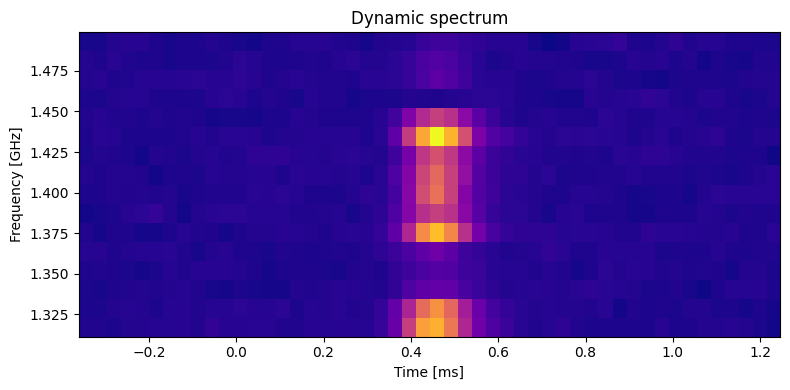

In [32]:
# Check burst spectrum
name = 'casey'
basedir = '/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/data/DSA_bursts/'
npys = os.listdir(f'{basedir}')
npy = [i for i in npys if f'{name}' in i][0]
dyn = np.load(os.path.join(basedir, npy))

#plt.plot(np.nansum(dyn,axis=0))
#plt.show()

# Setup the pipeline
name = 'casey'
basedir = '/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/data/DSA_bursts/'
npys = os.listdir(f'{basedir}')
npy = [i for i in npys if f'{name}' in i][0]
ds_path = os.path.join(basedir, npy)
tel_key = "DSA-110"             # key in telescopes.yaml

pipe = BurstPipeline(
    path           = ds_path,         
    telescope      = "DSA-110",
    telcfg_path    = "yaml/telescopes.yaml", 
    sampcfg_path   = "yaml/sampler.yaml",
    sampler_name   = None,   # or "dynesty", etc. to override YAML default
    #
    # Fitter
    n_steps        = 2000,
    pool           = pool,
    #
    # Dataset pre-processing
    f_factor       = 384,
    t_factor       = 1,
    outer_trim     = 0.49,
    center_burst   = True,
    smooth_ms      = 0.1,
)

# Quick-look the raw dynamic spectrum
pipe.dataset.quicklook()

for key in ("M0","M1","M2","M3"):
    p0  = pipe.fitter._guess()
    mdl = pipe.dataset.time.size
    ll  = pipe.fitter.model.log_likelihood(p0, key)
    print(f"{key}: logL = {ll:.1f}")
    
# Run the pipeline
result = pipe.run_full(
    model_scan=True,        # evaluates M0–M3, picks by BIC
    diagnostics=True,       # sub-band & leave-1-out tests
    plot=True,              # data, model, residual, influence bar
)

# After running the pipeline, display subband consistency results
if result["diagnostics"]:
    diag = result["diagnostics"]
    
    
    subband_results = diag.ds.__dict__.get('_subband_results', None)
    if subband_results and best_key in ["M2", "M3"]:
        print("\nSubband Consistency Test:")
        print("Band | τ_mean ± τ_std [ms]")
        print("-" * 30)
        for i, (tau_mean, tau_std) in enumerate(subband_results):
            print(f"{i+1:4d} | {tau_mean:.3f} ± {tau_std:.3f}")
            
# Examine the results
best_key   = result["best_key"]
best_pars  = result["best_params"]
sampler    = result["sampler"]

print("Best model :", best_key)
print("Parameters :", best_pars)

# Corner plot of posterior (discard burn-in, thin = 5)
flat = sampler.get_chain(discard=sampler.iteration//4, 
                         thin=5, flat=True)
fig  = corner.corner(flat, labels=list(best_pars.__dict__), 
                     show_titles=True)

#with contextlib.suppress(Exception):
#    pool.close(); pool.join()


N/50 = 20;
tau: [ 82.06855808  87.17953872 106.65394457  86.15796347]


Detected burn-in: 297 steps
Using thinning: 20
Final samples: 1120 (from 32000 total)
Removed 2 outlier samples
Chain Health Check:
  Log-prob stability: 16538.71 (want < 1.0)
  Parameter drift: 0.11 (want < 0.1)
  ⚠️  Chains may need more steps!
  Consider running: sampler.run_mcmc(None, 1000, progress=True)
Running additional MCMC steps...


100%|██████████| 1000/1000 [00:06<00:00, 143.91it/s]
N/50 = 40;
tau: [134.41809472 148.87033833 174.39532064 131.14953174]


Detected burn-in: 297 steps
Using thinning: 20
Final samples: 2720 (from 64000 total)
Removed 3 outlier samples

Parameter Summary (median [16%, 84%]):
c0: 0.049 [-0.020, 0.050]
t0: 0.460 [0.459, 1.175]
gamma: -5.140 [-5.299, -1.806]
zeta: -0.049 [-0.053, 0.066]


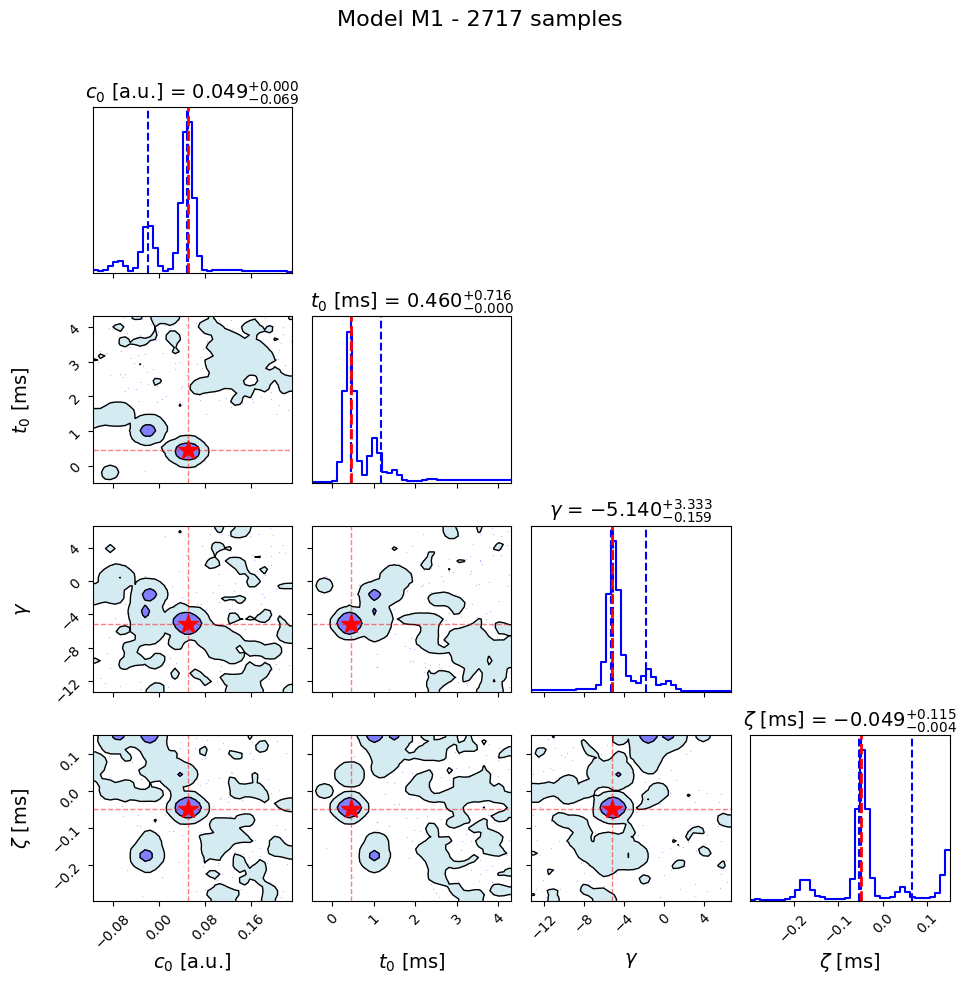

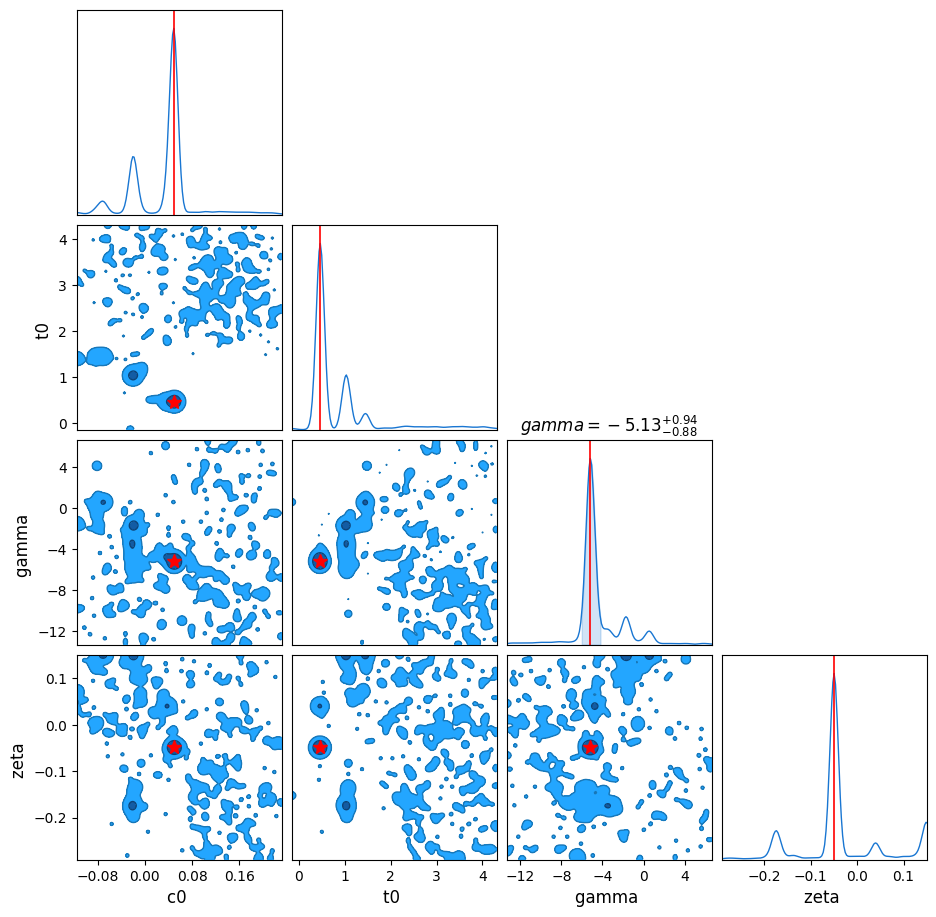

In [11]:
try:
    import chainconsumer
except:
    os.system('pip install chainconsumer --upgrade')
    
from chainconsumer import ChainConsumer

from burstfit_corner import (
        get_clean_samples,
        quick_chain_check,
        get_clean_samples,
        make_beautiful_corner
)
        
param_names = ["c0", "t0", "gamma", "zeta", "tau_1ghz"]

# Get clean samples
clean_samples = get_clean_samples(sampler, param_names, verbose=True)

# 1. Check convergence
is_converged = quick_chain_check(sampler)

if not is_converged:
    print("Running additional MCMC steps...")
    sampler.run_mcmc(None, 1000, progress=True)

# 2. Get clean samples
clean_samples = get_clean_samples(sampler, param_names[:sampler.ndim])

# 3. Make corner plot
fig = make_beautiful_corner(
    clean_samples,
    param_names[:sampler.ndim],
    best_params=best_pars,
    title=f"Model {best_key} - {clean_samples.shape[0]} samples"
)

# 4. Save if needed
fig.savefig(f'corner_plot_{best_key}.png', dpi=300, bbox_inches='tight')

def make_chainconsumer_plot(samples, param_names, best_params=None):
    
    # 1) build the corner from the real MCMC samples
    c = ChainConsumer()
    c.add_chain(samples, parameters=param_names, name="MCMC")
    c.configure(diagonal_tick_labels=False)

    fig = c.plotter.plot(figsize=(10, 10))

    # 2) overlay the best-fit point, if provided
    if best_params is not None:
        ndim = len(param_names)
        truths = np.array([getattr(best_params, n) for n in param_names])

        # ChainConsumer arranges axes row-major: ax_0, ax_1, … ax_{ndim**2-1}
        axes = np.array(fig.axes).reshape(ndim, ndim)

        # diagonal scatter
        for i in range(ndim):
            ax = axes[i, i]
            ax.axvline(truths[i], color="red", lw=1.2)

        # lower-triangle star markers
        for i in range(1, ndim):
            for j in range(i):
                ax = axes[i, j]
                ax.plot(truths[j], truths[i],
                        marker="*", ms=10, color="red", zorder=5)

    return fig


# Use it
fig = make_chainconsumer_plot(clean_samples,
                              param_names[:sampler.ndim],
                              best_pars)
plt.show()




=== DM Optimization Check ===
Optimal DM: 0.22 pc/cm³
DM offset: 0.22 pc/cm³


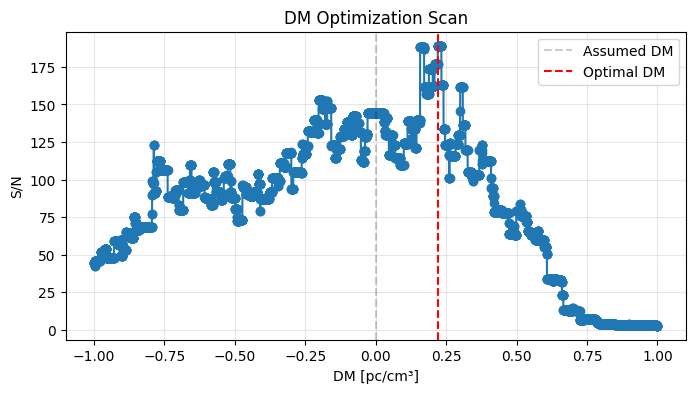

In [14]:
# 1. DM Optimization Check
print("\n=== DM Optimization Check ===")
dms, snrs = dm_optimization_check(
    pipe.dataset.data, 
    pipe.dataset.freq,
    pipe.dataset.time,
    dm_center=0.0,  # Your assumed DM
    dm_range=1.0,
    n_trials=5000
)

optimal_dm = dms[np.argmax(snrs)]
print(f"Optimal DM: {optimal_dm:.2f} pc/cm³")
print(f"DM offset: {optimal_dm:.2f} pc/cm³")

plt.figure(figsize=(8, 4))
plt.plot(dms, snrs, 'o-')
plt.axvline(0.0, color='k', alpha=0.2, linestyle='--', label='Assumed DM')
plt.axvline(optimal_dm, color='r', linestyle='--', label='Optimal DM')
plt.xlabel('DM [pc/cm³]')
plt.ylabel('S/N')
plt.title('DM Optimization Scan')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



         Using minimum window size of 0.3 ms (0 windows)

Burst characterization:
  Duration: 0.2 ms (8 samples)
  Time resolution: 0.033 ms/sample
  Window size: 0.2 ms (7 samples)
  SNR threshold: 3.0
  Peak SNR: 144.3

         Consider using global spectral index only.
         Trying with smaller window: 0.1 ms

Measurement results:
  Windows attempted: ~6
  Successful measurements: 6

Spectral indices:
  Window 1: t=0.39 ms, γ=-3.80±6.16
  Window 2: t=0.43 ms, γ=-8.69±7.61
  Window 3: t=0.46 ms, γ=-5.79±6.90
  Window 4: t=0.49 ms, γ=-5.32±6.68
  Window 5: t=0.52 ms, γ=-6.02±7.32
  Window 6: t=0.56 ms, γ=4.12±6.45


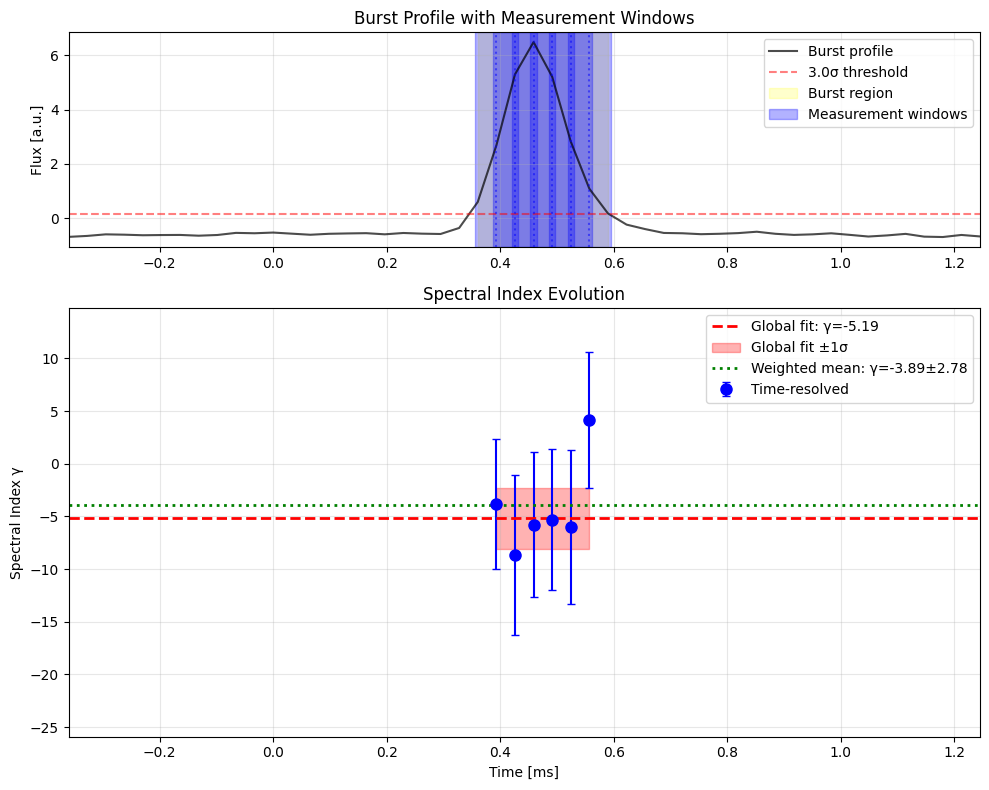


Statistical tests:
1. Consistency with global fit:
   χ² = 2.4 with 5 DOF
   p-value = 0.796

2. Linear trend test:
   Slope = 41.911 ± 29.092 ms⁻¹
   p-value = 0.223

Interpretation:
  ✓ No significant spectral evolution detected.
    Single spectral index model appears adequate.

3. Internal consistency of measurements:
   χ² = 2.1 with 5 DOF
   p-value = 0.828


In [29]:
def adaptive_spectral_evolution(pipe, best_pars, flat, param_names):
    """Run spectral evolution with parameters adapted to the burst"""
    # First, characterize the burst
    data = pipe.dataset.data
    time = pipe.dataset.time
    freq = pipe.dataset.freq
    
    time_profile = np.nansum(data, axis=0)
    noise_std = np.nanstd(time_profile[:len(time_profile)//4])
    
    # Use reasonable SNR threshold
    snr_threshold = 3.0  # Increased from 2.0 for more robust detection
    burst_mask = time_profile > snr_threshold * noise_std
    
    if not np.any(burst_mask):
        print("No samples above SNR threshold")
        return
    
    # Get burst duration
    burst_indices = np.where(burst_mask)[0]
    burst_duration_ms = (burst_indices[-1] - burst_indices[0]) * (time[1] - time[0])
    dt_ms = time[1] - time[0]
    
    # Calculate minimum viable window size
    min_samples_per_window = 10  # Need at least 10 samples for reliable average
    min_window_ms = min_samples_per_window * dt_ms
    
    # Adaptive window size - but ensure it's large enough
    target_windows = 5  # Aim for 5 windows across burst
    window_ms = burst_duration_ms / target_windows
    
    # Apply constraints
    if window_ms < min_window_ms:
        window_ms = min_window_ms
        actual_windows = int(burst_duration_ms / window_ms)
        print(f"WARNING: Burst too short for {target_windows} windows.")
        print(f"         Using minimum window size of {window_ms:.1f} ms ({actual_windows} windows)")
    
    window_ms = np.clip(window_ms, min_window_ms, burst_duration_ms)
    
    print(f"\nBurst characterization:")
    print(f"  Duration: {burst_duration_ms:.1f} ms ({len(burst_indices)} samples)")
    print(f"  Time resolution: {dt_ms:.3f} ms/sample")
    print(f"  Window size: {window_ms:.1f} ms ({int(window_ms/dt_ms)} samples)")
    print(f"  SNR threshold: {snr_threshold}")
    print(f"  Peak SNR: {np.max(time_profile)/noise_std:.1f}")
    
    # Check if burst is too short
    if burst_duration_ms < 2 * window_ms:
        print("\nWARNING: Burst duration < 2 window sizes.")
        print("         Consider using global spectral index only.")
        # Could still try with smaller window
        window_ms = burst_duration_ms / 3
        print(f"         Trying with smaller window: {window_ms:.1f} ms")
    
    # Now run spectral evolution
    from burstfit_robust import spectral_index_evolution
    times, gammas, gamma_errs = spectral_index_evolution(
        data, 
        freq, 
        time,
        window_ms=window_ms,
        min_snr=snr_threshold,
        stride_ms=window_ms/2,  # 50% overlap
        correct_for_scattering=False  # Set to True if you have tau_ref
    )
    
    print(f"\nMeasurement results:")
    print(f"  Windows attempted: ~{int(2 * burst_duration_ms / window_ms)}")
    print(f"  Successful measurements: {len(gammas)}")
    
    if len(gammas) > 0:
        # Print individual measurements
        print(f"\nSpectral indices:")
        for i, (t, g, ge) in enumerate(zip(times, gammas, gamma_errs)):
            print(f"  Window {i+1}: t={t:.2f} ms, γ={g:.2f}±{ge:.2f}")
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), height_ratios=[1, 2])
        
        # Top panel: burst profile with window positions
        ax1.plot(time, time_profile, 'k-', alpha=0.7, label='Burst profile')
        ax1.axhline(snr_threshold * noise_std, color='r', linestyle='--', 
                   alpha=0.5, label=f'{snr_threshold}σ threshold')
        
        # Show burst region
        ax1.axvspan(time[burst_indices[0]], time[burst_indices[-1]], 
                   alpha=0.2, color='yellow', label='Burst region')
        
        # Show window positions and sizes
        for i, t in enumerate(times):
            ax1.axvspan(t - window_ms/2, t + window_ms/2, 
                       alpha=0.3, color='blue', 
                       label='Measurement windows' if i == 0 else '')
            ax1.axvline(t, color='blue', alpha=0.5, linestyle=':')
        
        ax1.set_ylabel('Flux [a.u.]')
        ax1.set_title('Burst Profile with Measurement Windows')
        ax1.legend(loc='upper right')
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim(time[max(0, burst_indices[0]-50)], 
                     time[min(len(time)-1, burst_indices[-1]+50)])
        
        # Bottom panel: spectral evolution
        ax2.errorbar(times, gammas, yerr=gamma_errs, fmt='o', capsize=3, 
                    markersize=8, label='Time-resolved', color='blue')
        
        # Show the global fit value
        ax2.axhline(best_pars.gamma, color='r', linestyle='--', linewidth=2,
                   label=f'Global fit: γ={best_pars.gamma:.2f}')
        
        # Add shading for 1-sigma region from global fit
        if 'gamma' in param_names:
            gamma_idx = param_names.index('gamma')
            gamma_std = np.std(flat[:, gamma_idx])
            ax2.fill_between(times, 
                           best_pars.gamma - gamma_std,
                           best_pars.gamma + gamma_std,
                           alpha=0.3, color='red', label='Global fit ±1σ')
        
        # Add weighted mean of time-resolved measurements
        if len(gammas) > 1:
            weights = 1 / gamma_errs**2
            weighted_mean = np.sum(gammas * weights) / np.sum(weights)
            weighted_err = 1 / np.sqrt(np.sum(weights))
            ax2.axhline(weighted_mean, color='green', linestyle=':', linewidth=2,
                       label=f'Weighted mean: γ={weighted_mean:.2f}±{weighted_err:.2f}')
        
        ax2.set_xlabel('Time [ms]')
        ax2.set_ylabel('Spectral Index γ')
        ax2.set_title('Spectral Index Evolution')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim(ax1.get_xlim())
        
        # Set reasonable y-limits
        if len(gammas) > 0:
            y_range = max(3, 3 * np.median(gamma_errs))
            y_center = np.median(gammas)
            ax2.set_ylim(y_center - y_range, y_center + y_range)
        
        plt.tight_layout()
        plt.show()
        
        # Statistical tests
        if len(gammas) > 1:
            # Chi-squared test
            chi2_gamma = np.sum((gammas - best_pars.gamma)**2 / gamma_errs**2)
            dof = len(gammas) - 1
            p_value = 1 - sp.stats.chi2.cdf(chi2_gamma, df=dof)
            
            print(f"\nStatistical tests:")
            print(f"1. Consistency with global fit:")
            print(f"   χ² = {chi2_gamma:.1f} with {dof} DOF")
            print(f"   p-value = {p_value:.3f}")
            
            # Test for linear trend
            from scipy import stats
            slope, intercept, r_value, p_trend, std_err = stats.linregress(times, gammas)
            print(f"\n2. Linear trend test:")
            print(f"   Slope = {slope:.3f} ± {std_err:.3f} ms⁻¹")
            print(f"   p-value = {p_trend:.3f}")
            
            # Interpretation
            print(f"\nInterpretation:")
            if p_value < 0.05:
                print("  ⚠️  WARNING: Significant spectral evolution detected!")
                print("     The single spectral index model may be inadequate.")
                if p_trend < 0.05:
                    print("     There is a significant linear trend in the spectral index.")
            else:
                print("  ✓ No significant spectral evolution detected.")
                print("    Single spectral index model appears adequate.")
                
            # Check if measurements are consistent with each other
            chi2_internal = np.sum((gammas - weighted_mean)**2 / gamma_errs**2)
            p_internal = 1 - sp.stats.chi2.cdf(chi2_internal, df=dof)
            print(f"\n3. Internal consistency of measurements:")
            print(f"   χ² = {chi2_internal:.1f} with {dof} DOF")
            print(f"   p-value = {p_internal:.3f}")
            
            if p_internal < 0.05:
                print("   ⚠️  Measurements show significant scatter beyond errors.")
                print("      This could indicate:")
                print("      - Underestimated uncertainties")
                print("      - Real spectral variability")
                print("      - Systematic effects")
        
    else:
        print("\n❌ Failed to measure spectral indices")
        print("\nPossible reasons:")
        print("  1. Burst too short (< 1 ms)")
        print("  2. Burst too weak (low S/N)")
        print("  3. Too few frequency channels with signal")
        print("  4. Window size incompatible with burst structure")
        print(f"\nTry:")
        print(f"  - Reducing min_snr (currently {snr_threshold})")
        print(f"  - Using global fit only for this burst")
        print(f"  - Checking data quality")

# Add this import at the top of your script
import scipy as sp

# Run the adaptive version
adaptive_spectral_evolution(pipe, best_pars, flat, param_names)

Time samples: 50
Time range: -0.4 to 1.2 ms
Time resolution: 0.033 ms
Profile peak: 6.5
Noise std: 0.0
Peak SNR: 182.8

SNR > 3: 8 samples, 0.2 ms duration

SNR > 5: 7 samples, 0.2 ms duration

SNR > 10: 7 samples, 0.2 ms duration


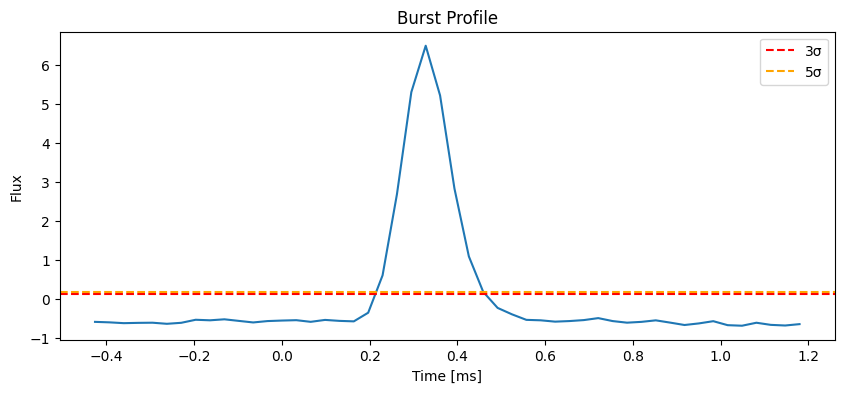

In [55]:
# Debug version to understand the issue
def debug_spectral_evolution(pipe):
    """Check why spectral evolution isn't working"""
    data = pipe.dataset.data
    time = pipe.dataset.time
    
    # Check burst profile
    time_profile = np.sum(data, axis=0)
    noise_std = np.std(time_profile[:len(time_profile)//4])
    
    print(f"Time samples: {len(time)}")
    print(f"Time range: {time[0]:.1f} to {time[-1]:.1f} ms")
    print(f"Time resolution: {time[1]-time[0]:.3f} ms")
    print(f"Profile peak: {np.max(time_profile):.1f}")
    print(f"Noise std: {noise_std:.1f}")
    print(f"Peak SNR: {np.max(time_profile)/noise_std:.1f}")
    
    # Find burst region
    for snr_thresh in [3, 5, 10]:
        burst_mask = time_profile > snr_thresh * noise_std
        if np.any(burst_mask):
            burst_indices = np.where(burst_mask)[0]
            burst_duration = (burst_indices[-1] - burst_indices[0]) * (time[1]-time[0])
            print(f"\nSNR > {snr_thresh}: {np.sum(burst_mask)} samples, {burst_duration:.1f} ms duration")
    
    # Plot to visualize
    plt.figure(figsize=(10, 4))
    plt.plot(time, time_profile)
    plt.axhline(3*noise_std, color='r', linestyle='--', label='3σ')
    plt.axhline(5*noise_std, color='orange', linestyle='--', label='5σ')
    plt.xlabel('Time [ms]')
    plt.ylabel('Flux')
    plt.title('Burst Profile')
    plt.legend()
    plt.show()
    
    return time_profile, noise_std

# Run the debug
profile, noise = debug_spectral_evolution(pipe)

In [56]:
# 2. Scintillation Analysis
print("\n=== Scintillation Analysis ===")

model = FRBModel(
    time=pipe.dataset.time, 
    freq=pipe.dataset.freq, 
    data=pipe.dataset.data,
    dm_init=0.0  # Use the same dm_init as in fit
)
model_dyn = model(best_pars, best_key)

residual = pipe.dataset.data - model_dyn
scint_results = scintillation_analysis(residual, pipe.dataset.freq, pipe.dataset.time)

if not np.isnan(scint_results['decorr_bw']):
    print(f"Decorrelation bandwidth: {scint_results['decorr_bw']:.1f} MHz")
    print(f"Modulation index: {scint_results['modulation_index']:.3f}")
    
    # Plot frequency ACF
    plt.figure(figsize=(8, 4))
    freq_lags = np.arange(len(scint_results['acf_freq'])) - len(scint_results['acf_freq'])//2
    plt.plot(freq_lags * (pipe.dataset.freq[1] - pipe.dataset.freq[0]) * 1000, 
             scint_results['acf_freq'])
    plt.axhline(1/np.e, color='r', linestyle='--', label='1/e level')
    plt.xlabel('Frequency Lag [MHz]')
    plt.ylabel('ACF')
    plt.title('Frequency Autocorrelation of Residuals')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()




=== Scintillation Analysis ===


In [57]:
# 3. Time-Frequency Drift Check
print("\n=== Time-Frequency Drift Check ===")
drift_results = time_frequency_drift_check(
    pipe.dataset.data, 
    pipe.dataset.freq,
    pipe.dataset.time, 
    model_dyn
)

print(f"Drift rate: {drift_results['drift_rate']:.3f} MHz/ms")
print(f"Drift significance: {drift_results['drift_snr']:.1f}σ")

if drift_results['drift_snr'] > 3:
    print("Significant drift detected!")
    # Show before/after drift correction
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    plot_dynamic(ax1, residual, pipe.dataset.time, pipe.dataset.freq, 
                 cmap='coolwarm', vmin=-0.1, vmax=0.1)
    ax1.set_title('Original Residual')
    
    plot_dynamic(ax2, drift_results['drift_corrected_residual'], 
                 pipe.dataset.time, pipe.dataset.freq,
                 cmap='coolwarm', vmin=-0.1, vmax=0.1)
    ax2.set_title('Drift-Corrected Residual')
    
    plt.tight_layout()
    plt.show()      
    



=== Time-Frequency Drift Check ===
Drift rate: -18.849 MHz/ms
Drift significance: 0.1σ


In [61]:
# 5. Bootstrap Uncertainties (optional - this is slow!)
if True:  # Set to True to run
    print("\n=== Bootstrap Error Analysis ===")
    boot_uncertainties = bootstrap_uncertainties(
        pipe.dataset.data,
        pipe.dataset.freq, 
        pipe.dataset.time,
        dm_init=0.0,
        best_params=best_pars,
        model_key=best_key,
        n_bootstrap=50,
        n_steps=300
    )
    
    print("Bootstrap uncertainties:")
    for param, (mean, std) in boot_uncertainties.items():
        print(f"{param}: {mean:.3f} ± {std:.3f}")  


=== Bootstrap Error Analysis ===
Running 50 bootstrap iterations...


 94%|█████████▎| 281/300 [00:00<00:00, 410.85it/s]


KeyboardInterrupt: 